# Studi Kasus ANOVA: Analisis Jumlah Penyelamatan Kiper FC Barcelona dalam Pertandingan untuk Menentukan Kiper FC Barcelona di Musim 2025/2026 (semoga juara UCL)


Dalam upaya memilih kiper utama FC Barcelona untuk musim mendatang, dilakukan analisis performa tiga kandidat: **Joan García, Marc-André ter Stegen, dan Wojciech Szczęsny.** Salah satu indikator penting dalam menilai kualitas penjaga gawang adalah **jumlah penyelamatan per pertandingan.**

Untuk menganalisis perbedaan performa secara objektif, digunakan metode Analisis Varians (ANOVA satu arah) terhadap **5 pertandingan terbaik dari masing-masing kiper selama musim 2024/2025.**

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. Menentukan Hipotesis

Menentukan hipotesis nol (H0) dan hipotesis alternatif (h1) dari variabel bebas yang merupakan 3 kiper FC Barcelona musim 2025/2026 yaitu
**Marc Andre Ter Stegen**, **Wojceich Szcensny**, dan kiper anyar **Joan Garcia**
dan juga berdasarkan variabel terikat yaitu berdasarkan **jumlah penyelamatan terbanyak dari 5 pertandingan di musim sebelumnya (2024/2025)**.

* **Hipotesis nol (H0)**
  
  Tidak terdapat perbedaan yang signifikan dalam rata-rata jumlah penyelamatan per pertandingan antara ketiga kiper (μ_Joan = μ_TerStegen = μ_Szczęsny).
* **Hipotesis alternatif (H1)**
  
  Terdapat perbedaan yang signifikan dalam rata-rata jumlah penyelamatan per pertandingan antara minimal dua kiper (setidaknya satu pasang μᵢ ≠ μⱼ).

Kita akan menggunakan tingkat signifikansi standar, yaitu α = 0.05. Artinya, kita bersedia menerima risiko 5% untuk salah menyimpulkan bahwa ada perbedaan padahal sebenarnya tidak ada.

# 2. Membuat Data Sampel

Seperti yang dijelaskan sebelumnya, data sampel yang akan digunakan adalah 5 pertandingan dengan jumlah penyelamatan terbanyak masing masing pemain di musim sebelumnya. Berikut adalah masing masing statistik penyelamatan terbanyak di musim 2024-2025 (Data dikutip dari situs [fbref.com](http://) )

# Joan Garcia

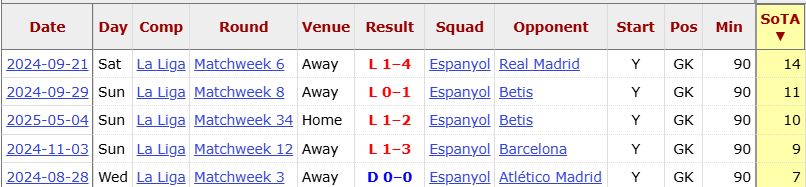

# Szcezsny

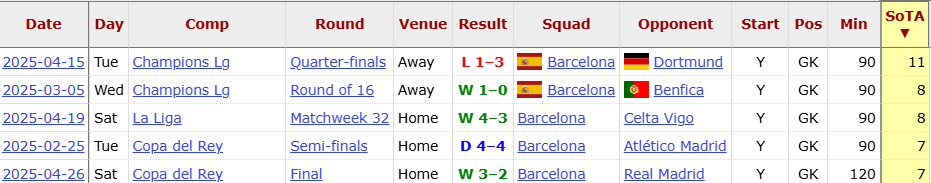


# Ter Stegen

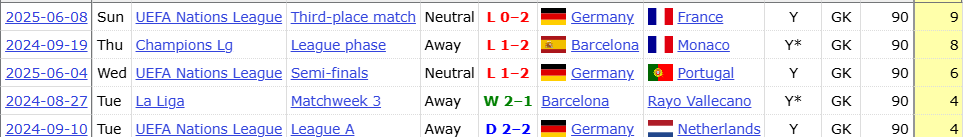


**Data yang digunakan: SoTA (Shots on Target Against)**

## Inisialisasi Data

In [15]:
##Joan Garcia
jg = [14,11,10,9,7]
##Szcesny
ws = [11,8,8,7,7]
##Ter Statue
ts = [9,8,6,4,4]

print("Sampel Data Penyelamatan Joan Garcia:", jg[:5])
print("Sampel Data Penyelamatan Szcezsny: ", ws[:5])
print("Sampel Data Penyelamatan Ter Stegen:  ", ts[:5])

Sampel Data Penyelamatan Joan Garcia: [14, 11, 10, 9, 7]
Sampel Data Penyelamatan Szcezsny:  [11, 8, 8, 7, 7]
Sampel Data Penyelamatan Ter Stegen:   [9, 8, 6, 4, 4]


# 3. Eksplorasi dan Visualisasi Data

In [16]:
data = {
    "Kiper": ["Joan Garcia", "Szczesny", "Ter Stegen"],
    "Mean": [np.mean(jg), np.mean(ws), np.mean(ts)],
    "Median": [np.median(jg), np.median(ws), np.median(ts)],
    "Max": [np.max(jg), np.max(ws), np.max(ts)],
    "Min": [np.min(jg), np.min(ws), np.min(ts)],
    "Std Dev": [np.std(jg, ddof=1), np.std(ws, ddof=1), np.std(ts, ddof=1)]
}

df_stat = pd.DataFrame(data)
print(df_stat)

         Kiper  Mean  Median  Max  Min   Std Dev
0  Joan Garcia  10.2    10.0   14    7  2.588436
1     Szczesny   8.2     8.0   11    7  1.643168
2   Ter Stegen   6.2     6.0    9    4  2.280351


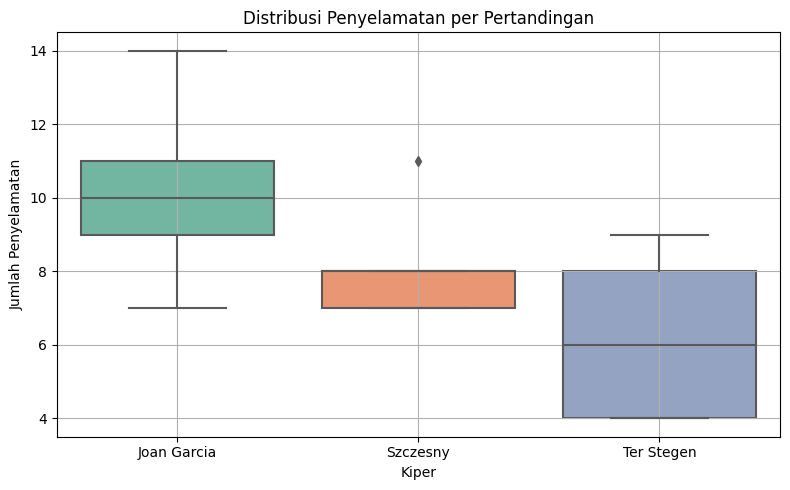

In [17]:
df = pd.DataFrame({
    'Kiper': ['Joan Garcia'] * len(jg) + ['Szczesny'] * len(ws) + ['Ter Stegen'] * len(ts),
    'Penyelamatan': jg + ws + ts
})

## Visualisasi Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Kiper', y='Penyelamatan', data=df, palette='Set2')
plt.title('Distribusi Penyelamatan per Pertandingan')
plt.ylabel('Jumlah Penyelamatan')
plt.xlabel('Kiper')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/4283624987.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Kiper', y='Penyelamatan', data=df, estimator='mean', ci='sd', palette='Set2')


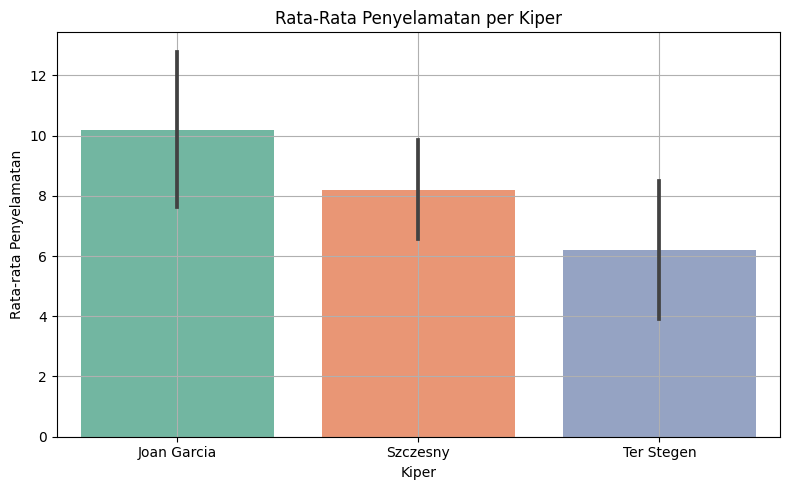

In [18]:
# Barplot rata-rata penyelamatan per kiper
plt.figure(figsize=(8, 5))
sns.barplot(x='Kiper', y='Penyelamatan', data=df, estimator='mean', ci='sd', palette='Set2')
plt.title('Rata-Rata Penyelamatan per Kiper')
plt.ylabel('Rata-rata Penyelamatan')
plt.xlabel('Kiper')
plt.grid(True)
plt.tight_layout()
plt.show()

Berdasarkan data Boxplot dan Barplot rata rata tersebut, didapatkan:

1. Joan Garcia mempunyai rata rata penyelamatan tertinggi
2. Nilai median Ter Stegen ter rendah, namun ia masih mempunyai nilai maksimum yang sama dengan Szcezsny

## 4. Melakukan Uji ANOVA (One-Way F-test)

Untuk menghitung F-statistic secara manual, kita perlu melalui beberapa langkah inti:
1. <b>Hitung Rata-rata (Mean)</b>: Hitung rata-rata untuk setiap kelompok dan rata-rata keseluruhan (Grand Mean).
2. <b>Hitung Sum of Squares (SS):</b>
- <b>Sum of Squares Between (SSB):</b> Variasi antar kelompok. Mengukur seberapa jauh rata-rata setiap kelompok dari Grand Mean.
- <b>Sum of Squares Within (SSW):</b> Variasi di dalam setiap kelompok. Mengukur seberapa menyebar data di dalam kelompoknya masing-masing.
3. <b>Hitung Degrees of Freedom (df):</b>
- <b>df between (dfb):</b> k - 1 (dimana k adalah jumlah kelompok).
- <b>df within (dfw):</b> N - k (dimana N adalah jumlah total semua sampel).
4. <b>Hitung Mean Square (MS):</b> Ini adalah rata-rata dari Sum of Squares.
- <b>MS Between (MSB):</b> SSB / dfb
- <b>MS Within (MSW):</b> SSW / dfw
5. <b>Hitung F-Statistic:</b> Rasio dari kedua Mean Square di atas. F = MSB / MSW.

In [19]:
# Gabungkan semua data menjadi satu list untuk perhitungan
semua_data = list(jg) + list(ws) + list(ts)
groups = [jg, ws, ts]
group_names = ['Joan Garcia', 'Szczesny', 'Ter Stegen']

# --- LANGKAH 1: HITUNG RATA-RATA ---
# Rata-rata untuk setiap kelompok
mean_jg = np.mean(jg)
mean_ws = np.mean(ws)
mean_ts = np.mean(ts)
group_means = [mean_jg, mean_ws, mean_ts]

# Rata-rata keseluruhan (Grand Mean)
grand_mean = np.mean(semua_data)

print("--- Rata-rata ---")
print(f"Rata-rata Joan Garcia : {mean_jg:.2f}")
print(f"Rata-rata Szczesny    : {mean_ws:.2f}")
print(f"Rata-rata Ter Stegen  : {mean_ts:.2f}")
print(f"Grand Mean (Keseluruhan): {grand_mean:.2f}\n")

# --- LANGKAH 2: HITUNG SUM OF SQUARES (SS) ---
# Sum of Squares Between (SSB)
ssb = 0
for i, group in enumerate(groups):
    ssb += len(group) * ((group_means[i] - grand_mean) ** 2)

# Sum of Squares Within (SSW)
ssw = 0
for i, group in enumerate(groups):
    sum_sq_group = sum((x - group_means[i]) ** 2 for x in group)
    ssw += sum_sq_group

print("--- Sum of Squares ---")
print(f"Sum of Squares Between (SSB): {ssb:.4f}")
print(f"Sum of Squares Within (SSW): {ssw:.4f}\n")

# --- LANGKAH 3: HITUNG DEGREES OF FREEDOM (df) ---
k = len(groups)       # Jumlah kelompok
N = len(semua_data)   # Jumlah total sampel
df_between = k - 1
df_within = N - k

print("--- Degrees of Freedom ---")
print(f"df Between: {df_between}")
print(f"df Within : {df_within}\n")

# --- LANGKAH 4: HITUNG MEAN SQUARE (MS) ---
msb = ssb / df_between
msw = ssw / df_within

print("--- Mean Square ---")
print(f"Mean Square Between (MSB): {msb:.4f}")
print(f"Mean Square Within (MSW): {msw:.4f}\n")

# --- LANGKAH 5: HITUNG F-STATISTIC ---
f_statistic_manual = msb / msw

print("--- Hasil Akhir ---")
print(f"F-Statistic (Perhitungan Manual): {f_statistic_manual:.4f}")

# Validasi dengan library Scipy
f_stat_scipy, p_val_scipy = stats.f_oneway(jg, ws, ts)
print(f"F-Statistic (Library Scipy):      {f_stat_scipy:.4f}")

# --- MENGHITUNG P-VALUE ---
p_value_manual = stats.f.sf(f_statistic_manual, df_between, df_within)

print(f"P-value (dari F-manual): {p_value_manual:.12f}")
print(f"P-value (dari Scipy):    {p_val_scipy:.12f}\n")

# Interpretasi hasil
alpha = 0.05
if p_value_manual < alpha:
    print("Kesimpulan: P-value < alpha (0.05). Kita MENOLAK Hipotesis Nol (H0).")
    print("Ada perbedaan signifikan jumlah penyelamatan antar kiper.")
else:
    print("Kesimpulan: P-value > alpha (0.05). Kita GAGAL MENOLAK Hipotesis Nol (H0).")
    print("Tidak ada perbedaan signifikan jumlah penyelamatan antar kiper.")

--- Rata-rata ---
Rata-rata Joan Garcia : 10.20
Rata-rata Szczesny    : 8.20
Rata-rata Ter Stegen  : 6.20
Grand Mean (Keseluruhan): 8.20

--- Sum of Squares ---
Sum of Squares Between (SSB): 40.0000
Sum of Squares Within (SSW): 58.4000

--- Degrees of Freedom ---
df Between: 2
df Within : 12

--- Mean Square ---
Mean Square Between (MSB): 20.0000
Mean Square Within (MSW): 4.8667

--- Hasil Akhir ---
F-Statistic (Perhitungan Manual): 4.1096
F-Statistic (Library Scipy):      4.1096
P-value (dari F-manual): 0.043702521193
P-value (dari Scipy):    0.043702521193

Kesimpulan: P-value < alpha (0.05). Kita MENOLAK Hipotesis Nol (H0).
Ada perbedaan signifikan jumlah penyelamatan antar kiper.


Meskipun ANOVA menunjukkan bahwa ada perbedaan signifikan antar kelompok, ANOVA tidak menjelaskan kelompok mana yang berbeda. Oleh karena itu, dibutuhkan uji lanjutan (post hoc) untuk:


* Mengetahui pasangan kiper mana yang berbeda secara signifikan.
* Menentukan siapa yang secara statistik lebih unggul atau lebih lemah dalam hal penyelamatan.


# 5. Uji lanjutan (Post hoc)

In [20]:
# Gabungkan data ke dalam DataFrame
data_tukey = pd.DataFrame({
    'Penyelamatan': jg + ws + ts,
    'Kiper': ['Joan Garcia'] * len(jg) + ['Szczesny'] * len(ws) + ['Ter Stegen'] * len(ts)
})

# Lakukan uji Tukey HSD
tukey = pairwise_tukeyhsd(endog=data_tukey['Penyelamatan'],
                          groups=data_tukey['Kiper'],
                          alpha=0.05)

# Tampilkan hasil
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2   meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
Joan Garcia   Szczesny     -2.0 0.3557 -5.7223  1.7223  False
Joan Garcia Ter Stegen     -4.0 0.0352 -7.7223 -0.2777   True
   Szczesny Ter Stegen     -2.0 0.3557 -5.7223  1.7223  False
-------------------------------------------------------------


# Kesimpulan

* Joan Garcia terbukti secara statistik lebih unggul dibanding Ter Stegen dalam jumlah penyelamatan pada 5 pertandingan terbaik musim 2024/2025.
* Namun, Joan Garcia dan Szczesny memiliki performa yang tidak berbeda secara signifikan. Sehingga Szcesny masih cukup layak untuk menjadi kiper cadangan
* Ter stegen dijual saja.

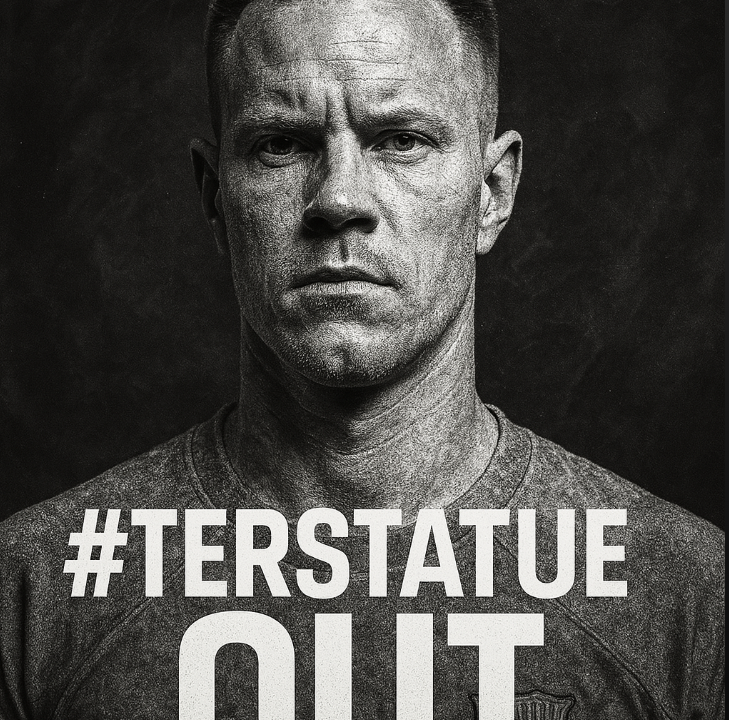